# Minimal Model

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [3]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

np.random.seed(42)

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


In [4]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(1.5, 5, 10000),

#                   bins=200, density=True)

# # plt.show()

In [5]:
# import matplotlib.pyplot as plt

# values = plt.hist(np.random.beta(5, 3, 10000),

#                   bins=200, density=True)

# plt.show()

In [40]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        
        
        # race
        self.race =  rng.binomial(1,0.2)#binary not white0.2 /  white for the moment 0.8
        
        if self.race == 0:
            self.wealth = rng.beta(1.5, 5,1)[0]
        else:
            self.wealth = rng.beta(5, 3,1)[0]
            

        # fraud
        self.fraud = rng.binomial(1,self.p.fraud_rate,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
        
        
    def fraud_algo(self):
        """ DM mechanism can also be ML"""
        rng = np.random.default_rng()
        # self.fraud_pred = rng.binomial(1, 0.5)
        if self.fraud == 1:
            fraud_cor = rng.binomial(1,self.p.acc)
        else:
            fraud_cor = rng.binomial(1,1-self.p.acc)
            
        self.fraud_pred = rng.binomial(1, fraud_cor*(0.8-self.p.wealth_appeal_corr))
        

            
    def convict(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud_pred == 1:
            if rng.binomial(1,self.p.conviction_rate) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - np.max([0.01,(pow(self.wealth,2)*0.1)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0
            
            
    def convict_true(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud == 1:
            if rng.binomial(1,self.p.conviction_rate) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - (0.1)#(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0

    def wealth_grow(self):
        self.wealth = min(1,self.wealth+pow(self.wealth,2)*0.1)
        
            


Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [41]:
class VirusModel(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """

#         # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        



    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        # general wealth 
        wealth = sum((self.agents).wealth) / len((self.agents))
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
        self.report('wealth', wealth)
            
        

In [42]:
class VirusModel_mvp(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """

#         # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
#         self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict_true()
        self.agents.wealth_grow()
        



    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        # general wealth 
        wealth = sum((self.agents).wealth) / len((self.agents))
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
        self.report('wealth', wealth)
            
            
        

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 50 steps
Run time: 0:00:01.304979
Simulation finished


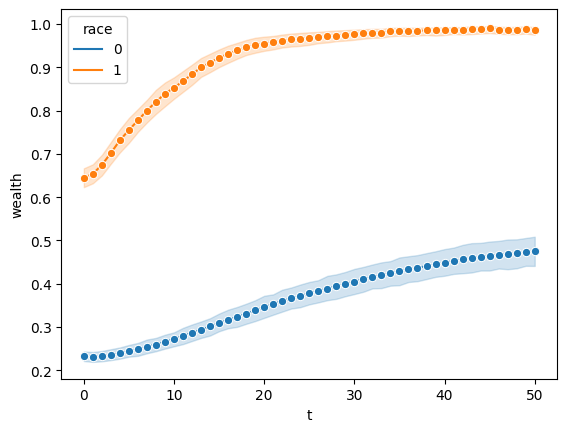

In [44]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':50,
    'fraud_rate':1, 
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'conviction_rate': 1,
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

Completed: 50 steps
Run time: 0:00:00.679393
Simulation finished


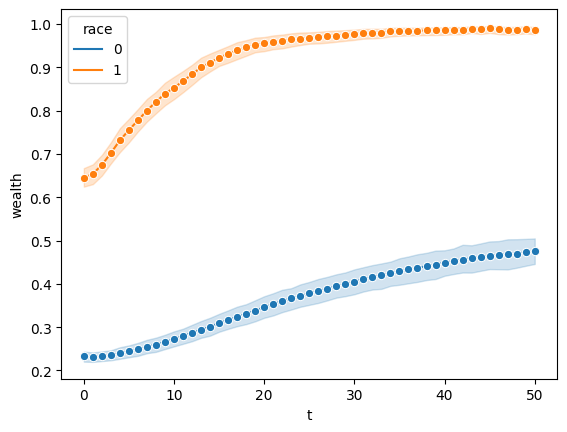

In [46]:
model = VirusModel_mvp(parameters)
results_mvp = model.run() 

df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

## Analyzing results

The simulation returns a :class:`DataDict` of recorded data with dataframes:

In [34]:
r =results['variables']['Person']
rmvp = results_mvp['variables']['Person']
x = r.index.get_level_values('t')
y = r['wealth'].astype(float)
hue = r['race']
xmvp = rmvp.index.get_level_values('t')
ymvp = rmvp['wealth'].astype(float)
huemvp = rmvp['race']

In [35]:
dy = ymvp - y


In [36]:
rw_mvp = rmvp[['wealth','race']]
rw_mvp

wealth  race
obj_id t                 
1      0   0.346868     0
       1   0.358900     0
       2   0.371781     0
       3   0.385603     0
       4   0.400472     0
...             ...   ...
50     46  1.000000     1
       47  1.000000     1
       48  1.000000     1
       49  1.000000     1
       50  1.000000     1

[2550 rows x 2 columns]

In [39]:
rw_mvp0 = (rmvp.loc[rmvp['race'] == 0]['wealth']).groupby('t').mean()
rw_mvp1 = (rmvp.loc[rmvp['race'] == 1]['wealth']).groupby('t').mean()

# rw_mvp0-rw_mvp1

In [37]:
r0 = (r.loc[r['race'] == 0]['wealth']).groupby('t').mean()
r1 = (r.loc[r['race'] == 1]['wealth']).groupby('t').mean()

# r0-r1

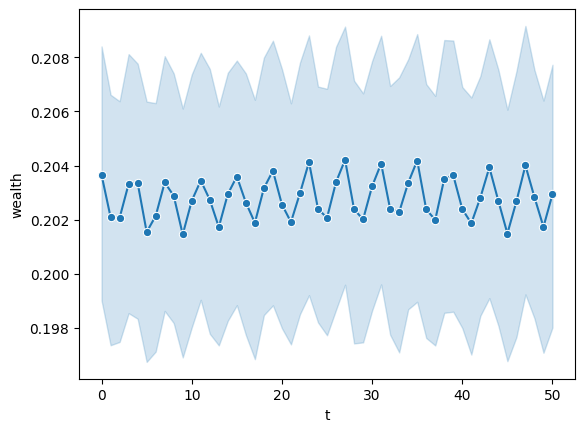

In [38]:
fig, ax = plt.subplots()
df = results['variables']['Person']
sns.lineplot(ax = ax,
             data = df,
             x = r.index.get_level_values('t'),
             y = dy,
#              hue = hue,
             marker = 'o')

plt.show()

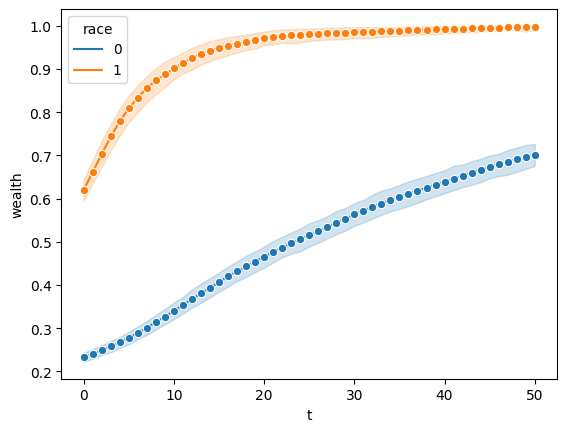

In [17]:
df = results['variables']['Person']
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = df,
             x = df.index.get_level_values('t'),
             y = df['wealth'].astype(float),
             hue = df['race'],
             marker = 'o')

plt.show()

To visualize the evolution of our variables over time, we create a plot function.

In [18]:
# def virus_stackplot(data, ax):
#     """ Stackplot of people's condition over time. """
#     x = data.index.get_level_values('t')
#     y = [data[var] for var in ['I', 'S', 'R']]
    
#     sns.set()
#     ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
#                  colors = ['r', 'b', 'g'])    
    
#     ax.legend()
#     ax.set_xlim(0, max(1, len(x)-1))
#     ax.set_ylim(0, 1)
#     ax.set_xlabel("Time steps")
#     ax.set_ylabel("Percentage of population")

# fig, ax = plt.subplots()
# virus_stackplot(results.variables.VirusModel, ax)

## Creating an animation

We can also animate the model's dynamics as follows.
The function :func:`animation_plot` takes a model instance 
and displays the previous stackplot together with a network graph. 
The function :func:`animate` will call this plot
function for every time-step and return an :class:`matplotlib.animation.Animation`.

In [19]:
# def animation_plot(m, axs):
#     ax1, ax2 = axs
#     ax1.set_title("Virus spread")
#     ax2.set_title(f"Share infected: {m.I}")
    
#     # Plot stackplot on first axis
#     virus_stackplot(m.output.variables.VirusModel, ax1)
    
#     # Plot network on second axis
#     color_dict = {0:'b', 1:'r', 2:'g'}
#     colors = [color_dict[c] for c in m.agents.condition]
#     nx.draw_circular(m.network.graph, node_color=colors, 
#                      node_size=50, ax=ax2)

# fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure 
# parameters['population'] = 50 # Lower population for better visibility 
# animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

Using Jupyter, we can display this animation directly in our notebook.

In [20]:
# IPython.display.HTML(animation.to_jshtml()) 

## Multi-run experiment

To explore the effect of different parameter values, 
we use the classes :class:`Sample`, :class:`Range`, and :class:`IntRange`
to create a sample of different parameter combinations.

What I want is trying a bunch of 

In [81]:
# parameters = {
#     'population': ap.IntRange(100, 1000),
#     'infection_chance': ap.Range(0.1, 1.),
#     'recovery_chance': ap.Range(0.1, 1.),
#     'initial_infection_share': 0.1,
#     'number_of_neighbors': 2,
#     'network_randomness': ap.Range(0., 1.)
# }
# parameters = {  
#     'population': 1000,
#     'infection_chance': 0.3,
#     'recovery_chance': 0.1,
#     'initial_infection_share': 0.1,
#     'number_of_neighbors': 2,
#     'network_randomness': 0.5   
# }

parameters = {
    'my_parameter':42,
    'agents': 100, #ap.IntRange(50, 150),
    'steps':50,
    'fraud_rate': ap.Range(0.,1),
    'wealth_appeal_corr': 0, #ap.Range(-0.2, 0.2), # >0 more wealth higher appeal chance
    'acc': 0.8, #ap.Range(0.5, 0.8), # accuracy of fraud prdediction
    'conviction_rate': 1, # ap.Range(0,1),
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
} 

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=False
)

We then create an :class:`Experiment` that takes a model and sample as input.
:func:`Experiment.run` runs our model repeatedly over the whole sample 
with ten random iterations per parameter combination.

In [82]:
exp = ap.Experiment(VirusModel_mvp, sample, iterations=2, record = True)
results = exp.run()

Scheduled runs: 768
Completed: 768, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:00:51.727449


Optionally, we can save and load our results as follows:

In [62]:
results.save()

Data saved to ap_output/VirusModel_mvp_4


In [63]:
results = ap.DataDict.load('VirusModel_mvp')

Loading from directory ap_output/VirusModel_mvp_4/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_Person.csv - Successful
Loading parameters_log.json - Successful


In [ ]:
results['reporters']

The measures in our :class:`DataDict` now hold one row for each simulation run.

In [ ]:
a =results['parameters']['sample']
a

In [ ]:
results['reporters']

We can use standard functions of the pandas library like 
:func:`pandas.DataFrame.hist` to look at summary statistics.

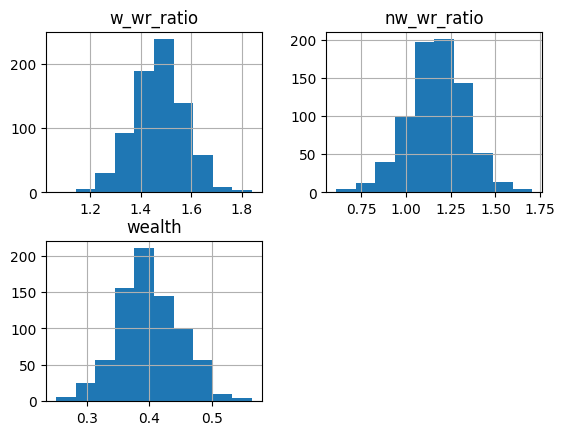

In [58]:
results.reporters.hist();

## Sensitivity analysis

The function :func:`DataDict.calc_sobol` calculates `Sobol sensitivity
indices <https://salib.readthedocs.io/en/latest/api.html#sobol-sensitivity-analysis>`_ 
for the passed results and parameter ranges, using the 
`SAlib <https://salib.readthedocs.io/en/latest/basics.html>`_ package. 

In [83]:
results.calc_sobol()

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/agentpy/datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 7 keys
    'sample': DataFrame with 1 variable and 384 rows
    'log': Dictionary with 5 keys
'variables': 
    'Person': DataFrame with 4 variables and 3916800 rows
'reporters': DataFrame with 4 variables and 768 rows
'sensitivity': 
    'sobol': DataFrame with 2 variables and 3 rows
    'sobol_conf': DataFrame with 2 variables and 3 rows
}

In [84]:
results['reporters']

seed  w_wr_ratio  \
sample_id iteration                                                        
0         0           95740343001821276743595980116694991492    1.674027   
          1          256370915509416580920841634747073216126    1.649918   
1         0          158344992888380243521309253484485806065    1.708133   
          1          298748566683519292357647299934875133928    1.649574   
2         0          311522194722098033510215059339942969641    1.536850   
...                                                      ...         ...   
381       1           99624650382060401635928362154267180259    1.586116   
382       0           13801112397104260046820164082899121316    1.712326   
          1          132487591289702720175525173729878047220    1.479155   
383       0          220133555909818518597415551169041784739    1.493171   
          1           28805518986631860013285131167841893718    1.440589   

                     nw_wr_ratio    wealth  
sample_id iteration                         
0         0             3.011974  0.750066  
          1             3.031964  0.776642  
1         0             2.178317  0.624283  
          1             2.374415  0.616312  
2         0             2.374354  0.630323  
...                          ...       ...  
381       1             3.045053  0.759715  
382       0             1.021687  0.360886  
          1             1.352624  0.487902  
383       0             1.130016  0.403997  
          1             1.346974  0.441866  

[768 rows x 4 columns]

In [85]:
si_list = results.sensitivity.sobol.groupby(by='reporter')
si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')
results.sensitivity.sobol

,,S1,ST
reporter,parameter,,
w_wr_ratio,fraud_rate,-0.043008,1.173680
nw_wr_ratio,fraud_rate,1.004308,1.045335
wealth,fraud_rate,0.904559,1.013653


This adds a new category `sensitivity` to our results, which includes:

- :attr:`sobol` returns first-order sobol sensitivity indices
- :attr:`sobol_conf` returns confidence ranges for the above indices

We can use pandas to create a bar plot that visualizes these sensitivity indices.

In [ ]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        print(si)
        si = si.droplevel('reporter')
        print(si)
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

     sample_id  iteration    wealth  fraud_rate
0          0.0        0.0  0.750066    0.011719
1          0.0        1.0  0.776642    0.011719
2          1.0        0.0  0.624283    0.332031
3          1.0        1.0  0.616312    0.332031
4          2.0        0.0  0.630323    0.332031
..         ...        ...       ...         ...
763      381.0        1.0  0.759715    0.003906
764      382.0        0.0  0.360886    0.996094
765      382.0        1.0  0.487902    0.996094
766      383.0        0.0  0.403997    0.996094
767      383.0        1.0  0.441866    0.996094

[768 rows x 4 columns]
Index(['fraud_rate'], dtype='object')


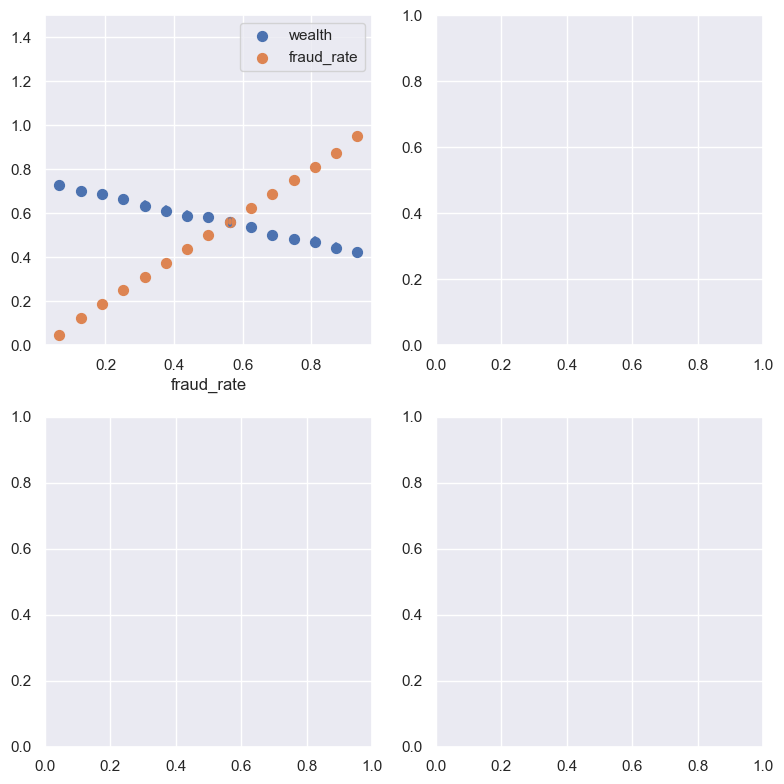

In [94]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters().astype('float')[["sample_id", "iteration", 'wealth', "fraud_rate"]]
    print(data)
    params = results.parameters.sample.keys() 
    print(params)
    
    for x, ax in zip(params, axs):
        for y in ['wealth', "fraud_rate"]:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0,1.5)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)